**Set up all the neccessary libraries**

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim import Adam
import nibabel as nib
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

**Check if the GPU is available**

If there is a GPU available, the device will be cuda otherwise it will be cpu

In [6]:
# Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')

Device : cuda


**Load dataset**

In [2]:
base_path = r'C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification'

train_path = os.path.join(base_path, 'Training')
testing_path = os.path.join(base_path, 'Testing')

if not (os.path.exists(train_path) and os.path.exists(testing_path)):
    print('Failed to find the data path ')
else:
    print(f'Training path : {train_path}')
    print(f'Testing path : {testing_path}')

Training path : C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification\Training
Testing path : C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification\Testing


In [3]:
# Define a Dataset class

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []

        # Mapping folder names to labels 
        class_folders = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_folder:idx for idx, class_folder in enumerate(class_folders)}

        for class_folder in class_folders:
            folder_path = os.path.join(root_dir,class_folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path,img_name)
                self.img_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_folder])

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image,label

In [4]:
# Define your transform
transform = transforms.Compose([
    # Randomly flip the image horizontally with a 50% chance
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Randomly flip the image vertically with a 50% chance
    transforms.RandomVerticalFlip(p=0.5),
    
    # Randomly rotate the image by ±10 degrees
    transforms.RandomRotation(degrees=10),
    
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    
    # Convert the image to a tensor with values in the range [0, 1]
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation
    # Use values based on your dataset, for example, for ImageNet:
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the dataset
train_dataset = CustomDataset(root_dir=train_path, transform=transform)
test_dataset = CustomDataset(root_dir=testing_path, transform=transform)



# Calculate lengths for training and validation sets
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split the dataset
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])




# Create DataLoaders for each subset
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=16, shuffle=False)

# Load the test dataset (remains unchanged)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [7]:
# Test data loader

# Iterate through the data by batch
for image, label in train_loader:
    # Move the data to GPU for fast training
    img = image.to(device)
    label = label.to(device)

    # We put break here since we just want to check only a single batch of the data
    break

print(img.shape)
print(label.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


**Teacher**

In [72]:

# Define the custom model
class Teacher(nn.Module):
    def __init__(self, num_classes=4, dropout_prob=0.2):
        super(Teacher, self).__init__()
        # Load the pre-trained MobileNetV2 model
        mobilenet = models.mobilenet_v2(pretrained=True)
        
        #freeze all layers
        for param in mobilenet.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom classifier
        self.features = mobilenet.features
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_prob),  # Dropout layer with 20% probability
            nn.Linear(mobilenet.last_channel, 512),  # Linear layer with 1000 output features
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout(p=dropout_prob),  # Additional dropout layer
            nn.Linear(512, num_classes)  # Final linear layer with 4 output classes
        )

        # Unfreeze the last 5 layers of MobileNetV2
        self.unfreeze_last_n_layers(mobilenet.features, 5)
        
    def unfreeze_last_n_layers(self, module, n):
        """
        Unfreeze the last `n` layers of a given module.
        """
        # Identify the named modules
        named_modules = list(module.named_children())
        # Iterate over the last `n` layers and unfreeze them
        for i, (name, child) in enumerate(named_modules[-n:]):
            for param in child.parameters():
                param.requires_grad = True
            print(f"Unfreezing layer: {name}")

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

In [73]:
# Instantiate the model
teacher = Teacher(num_classes=4)
teacher = teacher.to(device)

Unfreezing layer: 14
Unfreezing layer: 15
Unfreezing layer: 16
Unfreezing layer: 17
Unfreezing layer: 18


**Check the number of parameters**

In this part, we can check the number of parameters that either require or don't require gradient update.

In [74]:
# Calculate the total number of parameters
total_params_teacher = sum(p.numel() for p in teacher.parameters())

print(f'The number of parameters : {total_params_teacher}')

The number of parameters : 2881796


In [76]:
# Test the model and input compatability

test = teacher(img)

print(test.shape)

torch.Size([16, 4])


In [79]:
criterion = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(teacher.parameters(), lr=0.001)
scheduler_teacher = lr_scheduler.StepLR(optimizer_teacher, step_size=8, gamma=0.1)
num_epochs = 30
patience = 8
best_val_acc = 0.0
epochs_no_improve = 0

Epoch [1/15], Train Loss: 0.3850, Validation Loss: 0.2382, Validation Accuracy: 0.9129
Epoch [2/15], Train Loss: 0.3082, Validation Loss: 0.2390, Validation Accuracy: 0.9146
Epoch [3/15], Train Loss: 0.2957, Validation Loss: 0.2356, Validation Accuracy: 0.9251
Epoch [4/15], Train Loss: 0.2885, Validation Loss: 0.2165, Validation Accuracy: 0.9164
Epoch [5/15], Train Loss: 0.2656, Validation Loss: 0.1737, Validation Accuracy: 0.9425
Epoch [6/15], Train Loss: 0.2435, Validation Loss: 0.1868, Validation Accuracy: 0.9355
Epoch [7/15], Train Loss: 0.2395, Validation Loss: 0.1704, Validation Accuracy: 0.9373
Epoch [8/15], Train Loss: 0.1950, Validation Loss: 0.1677, Validation Accuracy: 0.9408
Epoch [9/15], Train Loss: 0.1868, Validation Loss: 0.1707, Validation Accuracy: 0.9338
Epoch [10/15], Train Loss: 0.1725, Validation Loss: 0.1674, Validation Accuracy: 0.9355
Epoch [11/15], Train Loss: 0.1794, Validation Loss: 0.1631, Validation Accuracy: 0.9443
Epoch [12/15], Train Loss: 0.1692, Valida

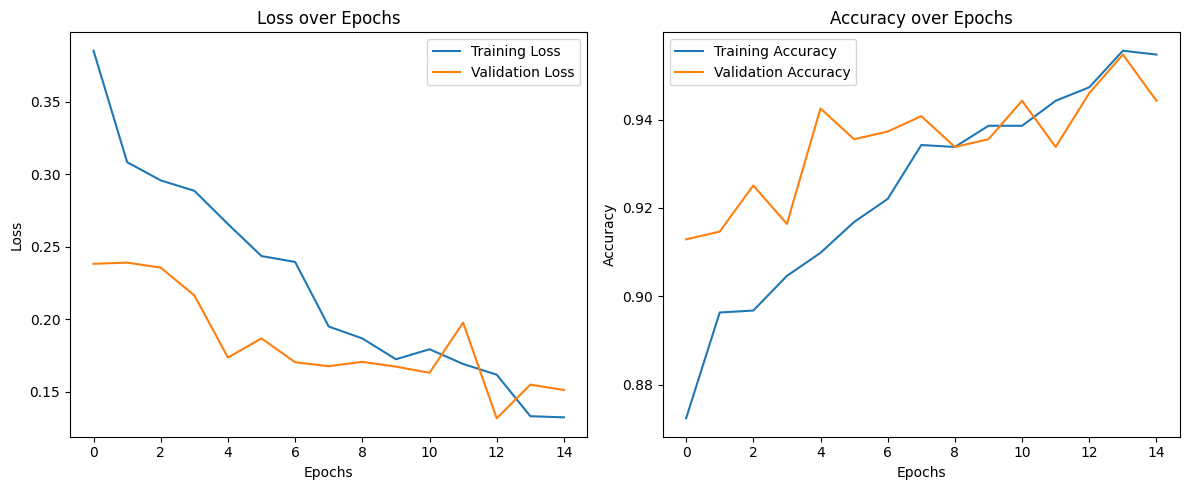

In [80]:
# Track Loss and Accuracy
num_epochs = 15
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    # Assign the model in the training mode
    teacher.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_teacher.zero_grad()

        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_teacher.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    train_accuracy.append(train_correct / train_total)

    # Validation Mode
    teacher.eval()
    val_correct = 0
    val_total = 0
    val_loss_epoch = 0  # Reset for validation loss

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = teacher(inputs)
            loss = criterion(predictions, labels)
            val_loss_epoch += loss.item()

            y_pred = torch.argmax(predictions, 1)
            val_correct += (y_pred == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss_epoch / len(valid_loader)
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_correct / val_total)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy[-1]:.4f}')

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Student**

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt


class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        # Use adaptive pooling to ensure a consistent output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))  # Final output size of 8x8
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjust in_features to match the output from pooling
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Pooling layer after conv1
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # Pooling layer after conv2
        
        # Apply adaptive pooling
        x = self.adaptive_pool(x)  # Output shape will be [batch_size, 64, 8, 8]
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [64]:
student = Student()
student = student.to(device)

In [89]:
# Calculate the total number of parameters
total_params_student = sum(p.numel() for p in student.parameters())

print(f'The number of parameters : {total_params_student}')

The number of parameters : 544324


In [66]:
# Test the model and input compatability
input_tensor = torch.randn(16, 3, 28, 28).to(device)  # Batch of 16 images
test = student(input_tensor)

print(test.shape)

torch.Size([16, 4])


**Knowledge Distillation + Adversarial Learning**

In [81]:
# Distillation Loss function
def distillation_loss(student_logits, teacher_logits, labels, T=3, alpha=0.7):
    soft_labels = F.softmax(teacher_logits / T, dim=1)
    distill_loss = F.kl_div(F.log_softmax(student_logits / T, dim=1), soft_labels, reduction='batchmean') * (T * T)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

In [82]:
# FGSM attack for adversarial examples
def fgsm_attack(model, data, epsilon, labels):
    data.requires_grad = True
    output = model(data)
    loss = F.cross_entropy(output, labels)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    return perturbed_data

**Train**

In [87]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
num_epochs = 10
patience = 8
best_val_acc = 0.0
epochs_no_improve = 0
epsilon = 0.01
T = 3
alpha = 0.8

In [88]:
# Track Loss and Accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    # Assign the model in the training mode
    teacher.eval()
    student.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_teacher.zero_grad()



         # Forward pass through teacher and student on clean data
        teacher_logits = teacher(inputs)
        student_logits = student(inputs)

        # Generate adversarial examples using FGSM attack
        adv_data = fgsm_attack(student, inputs, epsilon, labels)
        student_adv_logits = student(adv_data)

        # outputs = model(inputs)
        student_loss = criterion(student_logits, labels)
        #teacher_loss = criterion(teacher_logits, labels)

        # Generate adversarial examples using FGSM attack
        adv_data = fgsm_attack(student, inputs, epsilon, labels)
        student_adv_logits = student(adv_data)

        # Loss: Combine distillation loss and adversarial training loss
        loss_clean = distillation_loss(student_logits, teacher_logits, labels, T, alpha)
        loss_adv = F.cross_entropy(student_adv_logits, labels)
        loss = loss_clean + loss_adv + student_loss




        loss.backward()
        optimizer_teacher.step()
        running_loss += loss.item()


     # Calculate average loss and accuracy for the epoch
    
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)

    # Validation Mode
    student.eval()
    val_correct = 0
    val_total = 0
    val_loss_epoch = 0  # Reset for validation loss

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = student(inputs)
            loss = criterion(predictions, labels)
            val_loss_epoch += loss.item()

            y_pred = torch.argmax(predictions, 1)
            val_correct += (y_pred == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss_epoch / len(valid_loader)
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_correct / val_total)


    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy[-1]:.4f}')

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch [1/10], Train Loss: 3.0507, Validation Loss: 1.3799, Validation Accuracy: 0.2997
Epoch [2/10], Train Loss: 3.0505, Validation Loss: 1.3801, Validation Accuracy: 0.2962
Epoch [3/10], Train Loss: 3.0504, Validation Loss: 1.3798, Validation Accuracy: 0.2997


KeyboardInterrupt: 